In [81]:
# %load imports.py
%load_ext autoreload
%autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import brian2 as br
from brian2.units import *
import numpy as np

In [83]:
import warnings 
def set_parameters_from_dict(neurongroup, dictionary_of_parameters):
    for param_key, param_value in dictionary_of_parameters.items():
        try: 
            neurongroup.__setattr__(param_key, param_value)
        except AttributeError as err:
            warnings.warn("{:s} has no paramater {:s}".format(neurongroup.name, param_key))

# A simple winner-takes-it-all network

- show that two excitatory LIF neurons coupled via a common interneuron can compete and implement a kind of winner-takes-it-all network, where the neuron with more input suppresses its competitor
- implement a simple network in brian2 as a preparatory step to build the spatial network
- show $I_1-I_2$ and $r_1-r2$, should be non-linear

In [84]:
lif_model_eqs = """
dv/dt =1.0/tau* (-v + u_ext) :volt (unless refractory)
tau :second
u_ext = u_ext_const + u_ext_diff * sin(omega * t) : volt
u_ext_const : volt
u_ext_diff : volt
v_threshold: volt
v_reset: volt
tau_refractory: second
"""

delta_synapse_model = 'w: volt'
delta_synapse = 'v+=w'

threshold = "v>v_threshold"
reset = "v=v_reset"
refractory = "tau_refractory"

excitatory_neuron_properties = {
    "tau": 10*ms,
    "v_threshold": -40*mV,
    "v_reset": -55*mV,
    "tau_refractory": 5.5*ms
}

inhibitory_neuron_properties = {
    "tau": 7*ms,
    "v_threshold": -40*mV,
    "v_reset": -75*mV,
    "tau_refractory": 0.0*ms
}

duration = 1000*ms


In [85]:
# in_ex_connectivity=np.array([[1, 1], [0,1]]) #a one indicates a connection

In [86]:
excitatory_neurons = br.NeuronGroup(N=2, \
                                    name='excitatory_neurons',\
                                    model=lif_model_eqs, \
                                   threshold=threshold, \
                                   reset=reset,\
                                   refractory = refractory)

set_parameters_from_dict(excitatory_neurons, excitatory_neuron_properties)
excitatory_neurons.v = excitatory_neuron_properties["v_reset"]

inhibitory_neurons = br.NeuronGroup(N=1, \
                                    name='inhibitory_neurons',\
                                    model=lif_model_eqs, \
                                   threshold=threshold, \
                                   reset=reset,\
                                   refractory = refractory)

set_parameters_from_dict(inhibitory_neurons, inhibitory_neuron_properties)
inhibitory_neurons.v = inhibitory_neuron_properties["v_reset"]

excitatory_spike_recorder = br.SpikeMonitor(source=excitatory_neurons)
inhibitory_spike_recorder = br.SpikeMonitor(source=inhibitory_neurons)
exc_state_mon = br.StateMonitor(excitatory_neurons, 'v', record=True)
inh_state_mon = br.StateMonitor(inhibitory_neurons, 'v', record=True)
u_ext_mon = br.StateMonitor(excitatory_neurons, 'u_ext', record=True)

ex_in_synapses = br.Synapses(source=excitatory_neurons, target=inhibitory_neurons, model=delta_synapse_model, on_pre = delta_synapse )
ex_in_synapses.connect()

in_ex_synapses = br.Synapses(source=inhibitory_neurons, target=excitatory_neurons, model=delta_synapse_model, on_pre = delta_synapse )
in_ex_synapses.connect()


In [87]:
net = br.Network(excitatory_neurons, inhibitory_neurons)
net.add(ex_in_synapses, in_ex_synapses)
net.add(excitatory_spike_recorder, inhibitory_spike_recorder, exc_state_mon, inh_state_mon, u_ext_mon)
net.store()

In [88]:
def experiment(ex_const, ex_diff_1, ex_diff_2, in_drive, w_ex_in, w_in_ex, duration=1000*ms):
    net.restore()
    omega = 4 * np.pi / duration
    excitatory_neurons.u_ext_diff = [ex_diff_1, ex_diff_2]
    excitatory_neurons.u_ext_const = ex_const
    inhibitory_neurons.u_ext_const = in_drive
    inhibitory_neurons.u_ext_diff = 0.0
    ex_in_synapses.w = w_ex_in
    in_ex_synapses.w = w_in_ex
    net.run(duration=duration)
    return {
        "excitatory_spikes": excitatory_spike_recorder.spike_trains(),
        "inhibitory_spikes": inhibitory_spike_recorder.spike_trains(),
        "exc_state": exc_state_mon.v,
        "inh_state": inh_state_mon.v,
        "u_ext_trace": u_ext_mon.u_ext,
        "state_time": exc_state_mon.t
    }

In [89]:
u_ext_const = - 38 * mV
u_ext_diff_1 = 1.5 * mV
u_ext_diff_2 = -1.5 * mV

inhibitory_drive = -42*mV



In [90]:
ex_synaptic_strength = 10*mV
in_synaptic_strength = -60*mV
with_inhibitory_neuron = experiment(u_ext_const, u_ext_diff_1, u_ext_diff_2, inhibitory_drive, ex_synaptic_strength, in_synaptic_strength, duration) 

synaptic_strength = 0*mV
without_inhibitory_neuron = experiment(u_ext_const, u_ext_diff_1, u_ext_diff_2, inhibitory_drive, synaptic_strength, -synaptic_strength, duration)
    
    

INFO       No numerical integration method specified for group 'excitatory_neurons', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'inhibitory_neurons', using method 'euler' (took 0.01s, trying other methods took 0.01s). [brian2.stateupdaters.base.method_choice]


In [91]:
def get_excitatory_spike_count_difference(result_dict):
    return len(result_dict["excitatory_spikes"][0])-len(result_dict["excitatory_spikes"][1])

## Plot rate difference against drive difference

In [92]:
import matplotlib.pyplot as plt

In [94]:
def plot_spiking(result_dict):
    ex_spike_trains = result_dict["excitatory_spikes"]
    in_spike_trains = result_dict["inhibitory_spikes"]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    for key, times in ex_spike_trains.items():
        ax.plot(times/ms, key/2.0*np.ones(times.shape), 'b|')

    offset=2
    for key, times in in_spike_trains.items():
        ax.plot(times/ms, (key+offset)/2.0*np.ones(times.shape), 'r|')

    
    ax.grid(axis='x')
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlabel("Time(ms)");

In [95]:
def plot_states(result_dict):
    ex_state_mon = result_dict["exc_state"]
    in_state_mon = result_dict["inh_state"]
    state_t = result_dict["state_time"]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(state_t/ms, in_state_mon[0],'r')
    plt.plot(state_t/ms, ex_state_mon[0]-0.035*volt,'b')
    plt.plot(state_t/ms, ex_state_mon[1]-0.07*volt,'g')
    ax.grid(axis='x')
    ax.set_xlabel("Time(ms)");

In [96]:
def get_firing_rate(spike_train, t_win, time_points):
    firing_rate = np.zeros(time_points.shape)
    for i, t in enumerate(time_points):
        if t > 0.5 * t_win and t < time_points[-1] - 0.5 * t_win:
            firing_rate[i] = len([t_spike for t_spike in spike_train if t - 0.5 * t_win < t_spike and t_spike < t + 0.5 * t_win]) / t_win
#             firing_rate[i] = np.where(t - 0.5 * twin < spike_train and spike_train < t + 0.5 * twin).shape[0] / t_win
    return firing_rate
    
    

In [97]:
def plot_firing_rate(result_dict):
    ex_spike_trains = result_dict["excitatory_spikes"]
    in_spike_trains = result_dict["inhibitory_spikes"]
    state_t = result_dict["state_time"]
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    t_values = np.linspace(0.0,state_t[-1],500)
    plt.plot(t_values, get_firing_rate(in_spike_trains[0], 0.05 * state_t[-1], t_values), 'r')
    plt.plot(t_values, get_firing_rate(ex_spike_trains[0], 0.05 * state_t[-1], t_values), 'b')
    plt.plot(t_values, get_firing_rate(ex_spike_trains[1], 0.05 * state_t[-1], t_values), 'g')
#     plt.plot(state_t/ms, ex_state_mon[0]-0.035*volt,'b')
#     plt.plot(state_t/ms, ex_state_mon[1]-0.07*volt,'g')
    ax.grid(axis='x')
    ax.set_xlabel("Time(ms)");

In [98]:
def plot_firing_rate_hysteresis(result_dict):
    ex_spike_trains = result_dict["excitatory_spikes"]
    in_spike_trains = result_dict["inhibitory_spikes"]
    state_t = result_dict["state_time"]
    u_ext_list = result_dict['u_ext_trace']
    
    #Downsample
    n_samples = 500
    sample_ids = np.round(np.linspace(0, len(state_t) - 1, n_samples)).astype(int)
    t_values = state_t[sample_ids]
    u_ext_1 = u_ext_list[0]
    u_ext_2 = u_ext_list[1]
    u_ext_1_values = u_ext_1[sample_ids]
    u_ext_2_values = u_ext_2[sample_ids]
    u_ext_difference = u_ext_1_values - u_ext_2_values
    
    rate_1 = get_firing_rate(ex_spike_trains[0], 0.05 * t_values[-1], t_values)
    rate_2 = get_firing_rate(ex_spike_trains[1], 0.05 * t_values[-1], t_values)
    rate_diff = rate_1 - rate_2
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(u_ext_difference,rate_diff)
#     plt.plot(state_t/ms,u_ext_list[1])
#     plt.plot(state_t/ms, get_firing_rate(in_spike_trains[0], 500 * ms, state_t), 'r')
#     plt.plot(state_t/ms, get_firing_rate(ex_spike_trains[0], 500 * ms, state_t), 'b')
#     plt.plot(state_t/ms, get_firing_rate(ex_spike_trains[1], 500 * ms, state_t), 'g')

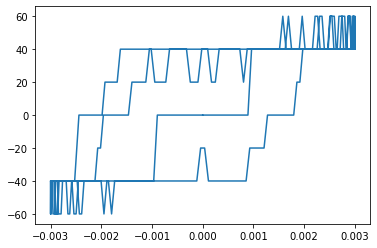

In [99]:
plot_firing_rate_hysteresis(with_inhibitory_neuron)

In [ ]:
# plot_firing_rate(with_inhibitory_neuron)

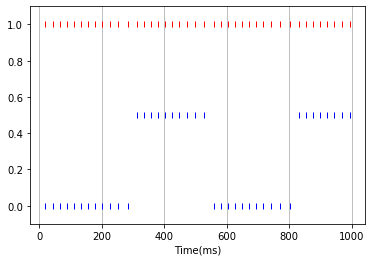

In [101]:
plot_spiking(with_inhibitory_neuron)

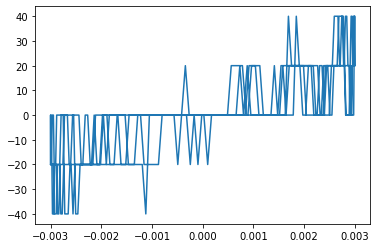

In [105]:
plot_firing_rate_hysteresis(without_inhibitory_neuron)

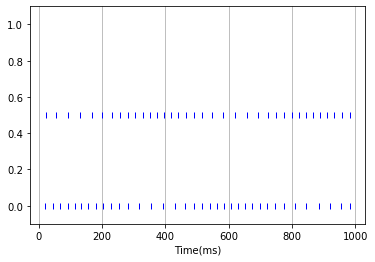

In [103]:
plot_spiking(without_inhibitory_neuron)